<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/implement-transformers-from-scratch/encoder_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import math # Python math module provides mathematical functions

import torch # PyTorch library (a popular DL framework)
import torch.nn as nn # (from PyTorch library) neural network module for building and training neural networks
import torch.nn.functional as F # (within nn module) functional submodule provides functions (such as activation functions, loss functions, and other operations) that are applied element-wise to tensors
from torch.utils.data import Dataset # Dataset class to customize datasets for training

import numpy as np # NumPy library for numerical operations in Python
import matplotlib.pyplot as plt # (from Matplotlib library) pyplot module for data visualization

# Implement the multi head attention (MHA):

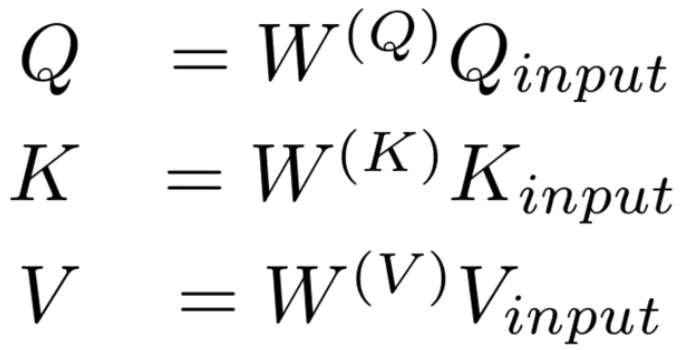

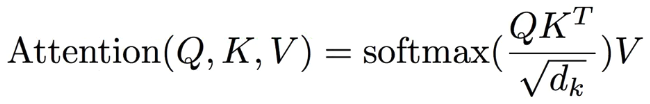

In [7]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, causal=False): # set causal mask as an option: False for encoder, True for decoder
    super().__init__()

    # Assume d_v = d_k
    self.d_k = d_k
    self.n_heads = n_heads

    self.key = nn.Linear(d_model, d_k * n_heads)
    self.query = nn.Linear(d_model, d_k * n_heads)
    self.value = nn.Linear(d_model, d_k * n_heads)

    # final linear layer
    self.fc = nn.Linear(d_k * n_heads, d_model)

    # causal mask
    # make it so that diagonal is 0 too
    # this way we don't have to shift the inputs to make targets
    self.causal = causal
    if causal:
      cm = torch.tril(torch.ones(max_len, max_len))
      self.register_buffer(
          "causal_mask",
          cm.view(1, 1, max_len, max_len)
      )

  def forward(self, q, k, v, pad_mask=None):
    q = self.query(q) # N x T x (hd_k)
    k = self.key(k)   # N x T x (hd_k)
    v = self.value(v) # N x T x (hd_v)

    N = q.shape[0]
    T_output = q.shape[1]
    T_input = k.shape[1]

    # change the shape to:
    # (N, T, h, d_k) -> (N, h, T, d_k)
    # in order for matrix multiply to work properly
    q = q.view(N, T_output, self.n_heads, self.d_k).transpose(1, 2)
    k = k.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
    v = v.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)

    # compute attention weights
    # (N, h, T, d_k) x (N, h, d_k, T) --> (N, h, T, T)
    attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
    if pad_mask is not None:
      attn_scores = attn_scores.masked_fill(
          pad_mask[:, None, None, :] == 0, float('-inf'))
    if self.causal:
      attn_scores = attn_scores.masked_fill(
          self.causal_mask[:, :, :T_output, :T_input] == 0, float('-inf'))
    attn_weights = F.softmax(attn_scores, dim=-1)

    # compute attention-weighted values
    # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
    A = attn_weights @ v

    # reshape it back before final linear layer
    A = A.transpose(1, 2) # (N, T, h, d_k)
    A = A.contiguous().view(N, T_output, self.d_k * self.n_heads) # (N, T, h*d_k)

    # projection
    return self.fc(A)

In [8]:
class EncoderBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.mha = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model),
        nn.Dropout(dropout_prob),
    )
    self.dropout = nn.Dropout(p=dropout_prob)

  def forward(self, x, pad_mask=None):
    x = self.ln1(x + self.mha(x, x, x, pad_mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)
    return x

In [9]:
class DecoderBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.ln3 = nn.LayerNorm(d_model)
    self.mha1 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=True)
    self.mha2 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model),
        nn.Dropout(dropout_prob),
    )
    self.dropout = nn.Dropout(p=dropout_prob)

  def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
    # self-attention on decoder input
    x = self.ln1(
        dec_input + self.mha1(dec_input, dec_input, dec_input, dec_mask))

    # multi-head attention including encoder output
    x = self.ln2(x + self.mha2(x, enc_output, enc_output, enc_mask))

    x = self.ln3(x + self.ann(x))
    x = self.dropout(x)
    return x

In [10]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=2048, dropout_prob=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout_prob)

    position = torch.arange(max_len).unsqueeze(1)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position * div_term)
    pe[0, :, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x):
    # x.shape: N x T x D
    x = x + self.pe[:, :x.size(1), :]
    return self.dropout(x)

In [11]:
class Encoder(nn.Module):
  def __init__(self,
               vocab_size,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
              #  n_classes,
               dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [
        EncoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    # self.fc = nn.Linear(d_model, n_classes)

  def forward(self, x, pad_mask=None):
    x = self.embedding(x)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(x, pad_mask)

    # many-to-one (x has the shape N x T x D)
    # x = x[:, 0, :]

    x = self.ln(x)
    # x = self.fc(x)
    return x

In [12]:
class Decoder(nn.Module):
  def __init__(self,
               vocab_size,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
               dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [
        DecoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    self.fc = nn.Linear(d_model, vocab_size)

  def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
    x = self.embedding(dec_input)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(enc_output, x, enc_mask, dec_mask)
    x = self.ln(x)
    x = self.fc(x) # many-to-many
    return x

In [13]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_input, dec_input, enc_mask, dec_mask):
    enc_output = self.encoder(enc_input, enc_mask)
    dec_output = self.decoder(enc_output, dec_input, enc_mask, dec_mask)
    return dec_output

In [14]:
# dummy test:
encoder = Encoder(vocab_size=20_000,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
decoder = Decoder(vocab_size=10_000,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
transformer = Transformer(encoder, decoder)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

cpu


Decoder(
  (embedding): Embedding(10000, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (mha2): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
 

In [16]:
xe = np.random.randint(0, 20_000, size=(8, 512))
xe_t = torch.tensor(xe).to(device)

xd = np.random.randint(0, 10_000, size=(8, 256))
xd_t = torch.tensor(xd).to(device)

maske = np.ones((8, 512))
maske[:, 256:] = 0
maske_t = torch.tensor(maske).to(device)

maskd = np.ones((8, 256))
maskd[:, 128:] = 0
maskd_t = torch.tensor(maskd).to(device)

out = transformer(xe_t, xd_t, maske_t, maskd_t)
out.shape

torch.Size([8, 256, 10000])

In [17]:
out

tensor([[[ 1.0686e+00,  6.9686e-01, -1.4472e-01,  ...,  9.6200e-01,
          -1.0530e+00,  9.7584e-01],
         [-7.6904e-02,  6.8253e-03,  9.7897e-02,  ...,  4.0133e-01,
          -1.2520e+00,  1.9627e-01],
         [ 7.3303e-01,  3.3649e-01,  1.0839e+00,  ..., -6.0969e-01,
          -8.0054e-01, -4.5156e-01],
         ...,
         [-4.7462e-01, -2.1596e-01, -3.8749e-01,  ..., -5.5131e-01,
          -1.1369e+00, -8.4126e-01],
         [-2.4864e-02, -2.3394e-01,  1.0329e-01,  ..., -2.5444e-01,
          -2.0269e-01,  2.2774e-01],
         [ 1.1774e-01,  4.7908e-02,  1.4301e+00,  ..., -3.2447e-01,
           9.9567e-01,  8.9525e-01]],

        [[ 5.0683e-01,  9.9281e-01,  3.2526e-01,  ...,  3.1996e-01,
          -9.7758e-02,  6.2419e-01],
         [ 5.7522e-01,  8.3624e-01, -5.6537e-02,  ...,  9.9155e-01,
          -3.2346e-01,  1.1764e+00],
         [ 1.2133e-01,  3.6545e-02, -1.6868e-02,  ...,  1.3371e-01,
          -9.7560e-01, -1.9330e-01],
         ...,
         [-1.8377e-01, -5

# Download actual data & train the model for translation:

In [18]:
# download en-sp dataset:
!wget -nc https://lazyprogrammer.me/course_files/nlp3/spa.txt

File ‘spa.txt’ already there; not retrieving.



In [19]:
!head spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Hi.	Hola.
Run!	¡Corre!
Who?	¿Quién?
Wow!	¡Órale!
Fire!	¡Fuego!
Fire!	¡Incendio!
Fire!	¡Disparad!


👆 2 columns: english on the left, and spanish on the right

In [20]:
import pandas as pd # import the `pandas` library for data manipulation and analysis (in DataFrames)

df = pd.read_csv('spa.txt', sep="\t", header=None) # read data from a Comma Separated Values file & store it in a DataFrame object
df.head()

,0,1
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Hi.,Hola.
4,Run!,¡Corre!


In [23]:
# check the shape of the DataFrame object:
df.shape

(30000, 2)

In [24]:
# takes too long, therefore only select the first 30,000 rows from the DataFrame:
df = df.iloc[:30_000] # integer-location based indexing

In [25]:
df.columns = ['en', 'es'] #  assigning column names to the DataFrame
df.to_csv('spa.csv', index=None) # save the DataFrame to a CSV file named 'spa.csv' without including the index

In [27]:
# display the first 10 lines of the CSV file:
!head spa.csv

en,es
Go.,Ve.
Go.,Vete.
Go.,Vaya.
Hi.,Hola.
Run!,¡Corre!
Who?,¿Quién?
Wow!,¡Órale!
Fire!,¡Fuego!
Fire!,¡Incendio!


In [28]:
# install some Python libraries using the pip package manager:
!pip install transformers datasets sentencepiece sacremoses
# transformers: for using pre-trained models
# datasets: to access various datasets
# sentencepiece: (a library for tokenization) to break down text into words or subwords
# sacremoses: (a library for tokenization) to prepare and clean text data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00


In [29]:
from datasets import load_dataset # import the function
raw_dataset = load_dataset('csv', data_files='spa.csv') # load dataset from a CSV file named 'spa.csv'

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [30]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 30000
    })
})

In [34]:
# perform a train-test split on the 'train' split of the dataset
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
# allocate 30% of the data to the test set, and 70% to the training
# set the random seed for reproducibility (ensuring that the same split is obtained each time the code is run)
split

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['en', 'es'],
        num_rows: 9000
    })
})

In [35]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

In [39]:
split["train"][0]

{'en': 'I can fix it.', 'es': 'Yo puedo arreglarlo.'}

In [38]:
# run a test:
en_sentence = split["train"][0]["en"] # retrieve the English sentence at the 1st index of the 'train' split from the previously created split variable
es_sentence = split["train"][0]["es"] # retrieve the spanish sentence (target)

inputs = tokenizer(en_sentence) # sentence -> tokenized format, which includes token IDs, attention masks, etc
targets = tokenizer(text_target=es_sentence) # similarly, tokenizer is applied to the Spanish sentence

# token IDs -> human-readable tokens, using the convert_ids_to_tokens method provided by the tokenizer
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Yo', '▁puedo', '▁arreglarlo', '.', '</s>']

👆  '▁' represents spaces, and `</s>` represents the end of the sequence.

In [40]:
inputs

{'input_ids': [33, 88, 9222, 48, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [42]:
targets

{'input_ids': [711, 1039, 44159, 3, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [46]:
max_input_length = 128
max_target_length = 128

def preprocess_function(batch):
    # tokenize the inputs:
    model_inputs = tokenizer(
        batch['en'], max_length=max_input_length, truncation=True)

    # tokenize the targets:
    # tokenized format: includes input_ids and attention_mask
    # eg: {'input_ids': [33, 88, 9222, 48, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}
    labels = tokenizer(
        text_target=batch['es'], max_length=max_target_length, truncation=True)

    # save tokenized input ids into 'model_inputs':
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [45]:
tokenized_datasets = split.map(
    preprocess_function,
    batched=True,
    remove_columns=split["train"].column_names,
)

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [47]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9000
    })
})

In [48]:
from transformers import DataCollatorForSeq2Seq # import the class for padding sequences to the same length and creating attention masks

data_collator = DataCollatorForSeq2Seq(tokenizer) # the collator will use this tokenizer to perform tokenization and padding operations on the sequences within a batch

In [49]:
# test data collator:
batch = data_collator([tokenized_datasets["train"][i] for i in range(0, 5)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [50]:
batch['input_ids']

tensor([[   33,    88,  9222,    48,     3,     0, 65000, 65000],
        [  552, 11490,     9,   310,   255,     3,     0, 65000],
        [  143,    31,   125,  1208,     3,     0, 65000, 65000],
        [ 1093,   220,  1890,    23,    48,     3,     0, 65000],
        [  124,    20,   100, 18422,    48,   141,     3,     0]])

👆 0 is a special token to mark the end (`[SEP]`), and 65000 is the padding token.

In [51]:
batch['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])

In [52]:
batch['labels']

tensor([[  711,  1039, 44159,     3,     0,  -100,  -100,  -100],
        [ 2722, 18663,   239,   212,     3,     0,  -100,  -100],
        [  539,    43,   155,   960,     3,     0,  -100,  -100],
        [15165,  1250,   380,  3564,    36,  1016,     3,     0],
        [  350,     8, 19153,    29, 31326,     3,     0,  -100]])

In [53]:
tokenizer.all_special_ids # access a list of all special token ([CLS], [SEP], [PAD]) IDs recognized by the tokenizer

[0, 1, 65000]

👆 0 for [CLS], 65000 for [PAD]

In [54]:
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>']

In [55]:
tokenizer('<pad>')

{'input_ids': [65000, 0], 'attention_mask': [1, 1]}

In [56]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)

valid_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=32,
    collate_fn=data_collator
)

In [57]:
# check how it works
for batch in train_loader:
  for k, v in batch.items():
    print("k:", k, "v.shape:", v.shape)
  break

k: input_ids v.shape: torch.Size([32, 10])
k: attention_mask v.shape: torch.Size([32, 10])
k: labels v.shape: torch.Size([32, 9])


In [58]:
tokenizer.vocab_size

65001

In [59]:
# add my own special token:
tokenizer.add_special_tokens({"cls_token": "<s>"})

1

In [61]:
tokenizer.all_special_ids

[0, 1, 65000, 65001]

In [60]:
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>', '<s>']

In [62]:
tokenizer("<s>")

{'input_ids': [65001, 0], 'attention_mask': [1, 1]}

In [64]:
# create enc, dec, trans objects:
encoder = Encoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
decoder = Decoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)
transformer = Transformer(encoder, decoder)

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder.to(device)
decoder.to(device)

cpu


Decoder(
  (embedding): Embedding(65002, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (mha2): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
 

In [67]:
# loss & optimizer:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(transformer.parameters())